In [1]:
import time

import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [2]:
def smiles_to_morgan_fingerprint(
        smi,
        radius=2,
        n_bits=1024
    ):
    mol = Chem.MolFromSmiles(smi)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    else:
        return None

# 1. Download (Prepare) the dataset to build binary classification models

In [3]:
'''
Download BBBP dataset from Therapeutic Data Commons
I loaded the prepared BBBP dataset in my local directory.
'''
data = pd.read_csv('/home/seongok/works/practice/gnn_lawa/data/bbbp.tab', sep='\t')
data

,Drug_ID,Drug,Y
0,Propanolol,CC(C)NCC(O)COc1cccc2ccccc12.[Cl],1
1,Terbutylchlorambucil,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1
2,40730,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1
3,24,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1
4,cloxacillin,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1
...,...,...,...
2034,licostinel,O=c1[nH]c2cc(Cl)c(Cl)c([N+](=O)[O-])c2[nH]c1=O,1
2035,ademetionine(adenosyl-methionine),C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc...,1
2036,mesocarb,CC(Cc1ccccc1)n1cc([N-]C(=O)Nc2ccccc2)[o+]n1,1
2037,tofisoline,CCc1c(C)[n+]([NH-])c(-c2ccc(OC)c(OC)c2)c2cc(OC...,1


# 2. Convert SMILES representation to Fingerprint (digitized vector representation)

In [4]:
fingerprints = []
labels = []
for index, row in data.iterrows():
    fingerprint = smiles_to_morgan_fingerprint(row['Drug'])
    if fingerprint is not None:
        fingerprints.append(fingerprint)
        labels.append(row['Y'])

# Convert fingerprints to NumPy arrays
X = np.array([np.array(fp) for fp in fingerprints])
y = np.array(labels)

[16:35:43] WARNING: not removing hydrogen atom without neighbors
[16:35:43] WARNING: not removing hydrogen atom without neighbors
[16:35:43] WARNING: not removing hydrogen atom without neighbors
[16:35:43] WARNING: not removing hydrogen atom without neighbors
[16:35:43] WARNING: not removing hydrogen atom without neighbors
[16:35:43] WARNING: not removing hydrogen atom without neighbors
[16:35:43] WARNING: not removing hydrogen atom without neighbors
[16:35:43] WARNING: not removing hydrogen atom without neighbors
[16:35:43] WARNING: not removing hydrogen atom without neighbors
[16:35:43] WARNING: not removing hydrogen atom without neighbors
[16:35:43] WARNING: not removing hydrogen atom without neighbors
[16:35:43] WARNING: not removing hydrogen atom without neighbors
[16:35:43] WARNING: not removing hydrogen atom without neighbors
[16:35:43] WARNING: not removing hydrogen atom without neighbors
[16:35:43] WARNING: not removing hydrogen atom without neighbors
[16:35:43] WARNING: not r

In [5]:
X, X.shape

(array([[0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]]),
 (2039, 1024))

In [6]:
y, y.shape

(array([1, 1, 1, ..., 1, 1, 1]), (2039,))

# 3. Split the dataset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025, stratify=y)

In [8]:
X_train.shape, y_train.shape

((1631, 1024), (1631,))

In [9]:
X_test.shape, y_test.shape

((408, 1024), (408,))

# 4. (Optional) Scaling the input vectors

In [10]:
# Normalize the data for better SVM performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
X_train_scaled[0], X_test_scaled[0]

(array([-0.10856611, -0.56059138,  4.5869969 , ..., -0.18326707,
        -0.13454506, -0.10262961]),
 array([-0.10856611, -0.56059138, -0.21800756, ..., -0.18326707,
        -0.13454506, -0.10262961]))

# 5. Logistic Regression

In [12]:
# Logistic Regression Model with scaling
st = time.time()
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)
et = time.time()

In [13]:
accuracy_score(y_test, y_pred_log_reg)

0.8161764705882353

In [14]:
print(classification_report(y_test, y_pred_log_reg))

              precision    recall  f1-score   support

           0       0.62      0.57      0.59        96
           1       0.87      0.89      0.88       312

    accuracy                           0.82       408
   macro avg       0.74      0.73      0.74       408
weighted avg       0.81      0.82      0.81       408



In [15]:
print ("Time for logistic regression", round(et-st, 2), "(s)")

Time for logistic regression 0.26 (s)


In [16]:
# Logistic Regression Model without scaling
st = time.time()
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
et = time.time()

In [17]:
accuracy_score(y_test, y_pred_log_reg)

0.875

In [18]:
print(classification_report(y_test, y_pred_log_reg))

              precision    recall  f1-score   support

           0       0.78      0.65      0.71        96
           1       0.90      0.95      0.92       312

    accuracy                           0.88       408
   macro avg       0.84      0.80      0.81       408
weighted avg       0.87      0.88      0.87       408



In [19]:
print ("Time for logistic regression", round(et-st, 2), "(s)")

Time for logistic regression 0.08 (s)


# 6. Support vector machine 

In [20]:
# Support Vector Machine Model without scaling
st = time.time()
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
et = time.time()

In [21]:
accuracy_score(y_test, y_pred_svm)

0.8676470588235294

In [22]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.79      0.59      0.68        96
           1       0.88      0.95      0.92       312

    accuracy                           0.87       408
   macro avg       0.84      0.77      0.80       408
weighted avg       0.86      0.87      0.86       408



In [23]:
print ("Time for support vector machine", round(et-st, 2), "(s)")

Time for support vector machine 4.71 (s)


In [24]:
# Support Vector Machine Model with scaling
st = time.time()
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
et = time.time()

In [25]:
accuracy_score(y_test, y_pred_svm)

0.8700980392156863

In [26]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.84      0.55      0.67        96
           1       0.88      0.97      0.92       312

    accuracy                           0.87       408
   macro avg       0.86      0.76      0.79       408
weighted avg       0.87      0.87      0.86       408



In [27]:
print ("Time for support vector machine", round(et-st, 2), "(s)")

Time for support vector machine 5.85 (s)


# 7. Evaluation of classification results

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [29]:
def binary_classification_evaluation(y_true, y_pred, prob_pred):
    accuracy = accuracy_score(y_true, y_pred)
    auroc = roc_auc_score(y_true, prob_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1_score = 2.0 * precision * recall / (precision + recall)
    print ("Accuracy:", round(accuracy, 3), \
            "AUROC:", round(auroc, 3), \
            "Precision:", round(precision, 3), \
            "Recall:", round(recall, 3), 
            "F1-score:", round(f1_score, 3))

In [30]:
prob_log_reg = log_reg.predict_proba(X_test)[:,1]
prob_svm = svm_model.predict_proba(X_test_scaled)[:,1]

In [31]:
y_pred_log_reg[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [32]:
prob_log_reg[:10]

array([0.99894507, 0.85632137, 0.98659127, 0.99604004, 0.96453993,
       0.91856059, 0.9849731 , 0.96445524, 0.97751915, 0.99270484])

In [33]:
# Logistic regression
binary_classification_evaluation(y_true=y_test, y_pred=y_pred_log_reg, prob_pred=prob_log_reg)

Accuracy: 0.875 AUROC: 0.87 Precision: 0.897 Recall: 0.946 F1-score: 0.92


In [34]:
# Support vector machine
binary_classification_evaluation(y_true=y_test, y_pred=y_pred_svm, prob_pred=prob_svm)

Accuracy: 0.87 AUROC: 0.886 Precision: 0.875 Recall: 0.968 F1-score: 0.919


# 8. Calibration curve and Expected Calibration Error (ECE)

In [35]:
import matplotlib.pyplot as plt

In [36]:
def calibration(
        label,
        pred,
        bins=10
    ):

    width = 1.0 / bins
    bin_centers = np.linspace(0, 1.0-width, bins) + width/2

    conf_bin = []
    acc_bin = []
    counts = []
    for i, threshold in enumerate(bin_centers):
        bin_idx = np.logical_and(
            threshold - width/2 < pred,
            pred <= threshold + width
        )
        conf_mean = pred[bin_idx].mean()
        conf_sum = pred[bin_idx].sum()
        if (conf_mean != conf_mean) == False:
            conf_bin.append(conf_mean)
            counts.append(pred[bin_idx].shape[0])

        acc_mean = label[bin_idx].mean()
        acc_sum = label[bin_idx].sum()
        if (acc_mean != acc_mean) == False:
            acc_bin.append(acc_mean)

    conf_bin = np.asarray(conf_bin)
    acc_bin = np.asarray(acc_bin)
    counts = np.asarray(counts)

    ece = np.abs(conf_bin - acc_bin)
    ece = np.multiply(ece, counts)
    ece = ece.sum()
    ece /= np.sum(counts)
    return conf_bin, acc_bin, ece

In [37]:
bins = 10

In [38]:
conf_lr, acc_lr, ece_lr = calibration(y_test, prob_log_reg, bins=bins)
ece_lr

0.06332570673035513

In [39]:
conf_svm, acc_svm, ece_svm = calibration(y_test, prob_svm, bins=bins)
ece_svm

0.02786626605482945

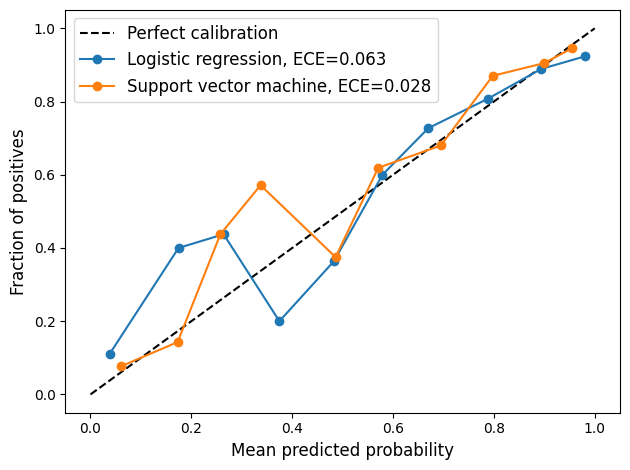

In [40]:
plt.figure()
plt.plot([0,1], [0,1], '--', c='k', label='Perfect calibration')
plt.plot(conf_lr, acc_lr, '-o', label='Logistic regression, ECE=' + str(round(ece_lr, 3)))
plt.plot(conf_svm, acc_svm, '-o', label='Support vector machine, ECE=' + str(round(ece_svm, 3)))

plt.xlabel('Mean predicted probability', fontsize=12)
plt.ylabel('Fraction of positives', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()